## 모듈 선언

In [1]:
import os
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import json
from soynlp.normalizer import *
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np

`from soynlp.normalizer import *`  
한국어 분석을 위한 pure python code
- 학습데이터를 이용하지 않으면서 데이터에 존재하는 단어를 찾거나, 문장을 단어열로 분해, 혹은 품사 판별을 할 수 있는 비지도학습 접근법을 지향합니다.
- [Github Link](https://github.com/lovit/soynlp)

---



## 파일 읽기

### 1) Train Data

#### CSV file read (as DataFrame)

In [2]:
train_data_path ="/aiffel/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)

#### Data Read (with `tail`)

In [3]:
train_data.tail()

,idx,class,conversation
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...


#### Data Read (by case)

##### case 1. 협박

In [4]:
print(train_data['conversation'][0]) # 협박

지금 너 스스로를 죽여달라고 애원하는 것인가?
 아닙니다. 죄송합니다.
 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.
 정말 잘못했습니다.
 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.
 죄송합니다. 정말 잘못했습니다.
 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.
 선택 못하겠습니다. 한번만 도와주세요.
 그냥 다 죽여버려야겠군. 이의 없지?
 제발 도와주세요.


##### case 2. 기타 괴롭힘

In [5]:
print(train_data['conversation'][2]) # 기타 괴롭힘

너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.
그만해. 니들 놀리는거 재미없어.
지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네?
너 군대도 안가고 좋겠다.
니들이 나 작은데 보태준거 있냐?
난쟁이들도 장가가고하던데. 너도 희망을 가져봐 
더이상 하지마라. 
그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디?
나람 해줬어. 저 키로 어찌살아.
제발 그만 괴롭히라고!


##### case 3. 갈취

In [6]:
print(train_data['conversation'][3]) # 갈취

어이 거기
예??
너 말이야 너. 이리 오라고
무슨 일.
너 옷 좋아보인다?
얘 돈 좀 있나봐
아니에요.돈 없어요
뒤져서 나오면 넌 죽는다
오늘 피시방 콜?
콜. 마지막 기회다. 있는거 다 내놔
정말 없어요


##### case 4. 직장 내 괴롭힘

In [7]:
print(train_data['conversation'][3947]) # 직장 내 괴롭힘

나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.
왜 그래. 들리겠어.
들리라고 해. 아니 일 못해 눈치 없어. 본인도 슬슬 깨달아야 되지 않나?
하긴 그래서 저번에 부장님도.
그렇다니깐! 부장님이 진짜 착하신 분인데 오죽 답답했으면 말을 했겠어?
그러게.
회사생활 같이 한게 몇년인데 대답 하나 제대로 네 하고 싹싹하게 하는걸 못봤어.
나도 그건 못본거 같다.
지금도 그래. 야 야! 너 바로 앞에서 얘기하는데 귀가 먹어서 안들리는거니 안들리는척 하는거니? 뭐 말 좀 해봐?
야 너 왜 그래.
말씀이 너무 심하신거 아니에요?


#### Data Read (Check null data)

In [8]:
train_data.isna().sum()

idx             0
class           0
conversation    0
dtype: int64

---

## 데이터 변환

### 1) 문장 전처리 함수 선언

#### `preprocess_sentence()`
1. 영어, 한국어가 아닌 경우 공백 (` `) 처리
2. 두 개 이상의 느낌표(`!+`)가 있을 경우 느낌표 하나로 처리
3. 두 개 이상의 물음표(`\?+`)가 있을 경우 물음표 하나로 처리
4. `?`, `.`, `!`, `,` 가 있을 경우 그 주위에 공백을 추가
5. 연속적인 공백이 있을 시 공백을 하나로 처리
6. 문장 앞뒤의 공백과 개행문자를 제거(`strip`)

In [9]:
def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣?.!,])', " ", sentence)
    sentence = re.sub(r'!+', '!', sentence)
    sentence = re.sub(r'\?+', '?', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### 2) `preprocess_sentence()` 사용해 학습할 문장(`sentences`) 설정

In [10]:
# 학습할 문장이 담길 배열
sentences = []

for val in tqdm(train_data['conversation'], desc="Generate sentences.."):
    # preprocess_sentence()로 문장(val)을 전처리하여 배열에 저장
    sentences.append(preprocess_sentence(val))

Generate sentences..: 100%|██████████| 3950/3950 [00:01<00:00, 3328.37it/s]


In [11]:
# 대화 데이터 개수 파악
len(sentences)

3950

### 3) 대화 분류값(`class`)를 `labels`에 저장

#### `class` 값은 숫자로 변환하여 `labels`에 저장한다
- `협박 관련 대화` &rarr; `0`
- `갈취 관련 대화` &rarr; `1`
- `직장 관련 대화` &rarr; `2`  
- `기타 관련 대화` &rarr; `3`

In [12]:
labels = []

for val in tqdm(train_data['class'], desc="class label convert to num..."):    
    if '갈취' in val:
        labels.append(1)
    if '기타' in val:
        labels.append(3)
    if '직장' in val:
        labels.append(2)
    if '협박' in val:
        labels.append(0)

class label convert to num...: 100%|██████████| 3950/3950 [00:00<00:00, 1314463.73it/s]


In [13]:
# labels 개수 파악
len(labels)

3950

### 4) 사용하지 않는 변수 초기화

In [14]:
del train_data

---

## 모델 학습 준비

### 1) 모델 학습용 파라미터 선언

In [15]:
# 토큰 최대 길이
MAX_LEN = 128
# 데이터 묶음 크기
BATCH_SIZE = 16
# Learning Rate
lr = 1e-5
# 훈련 횟수
EPOCH = 3

### 2) 데이터셋 분할
1. `sentences`와 `labels`를 활용
2. `8:2` 비율로 `train`, `validation` 데이터셋으로 분할

In [16]:
# 데이터셋 분할
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

### 3) 모델 선언
1. 모델: `bert-base-multilingual-cased`
2. BERT 토크나이저 사용

In [17]:
# BERT 토크나이저와 모델 준비
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4) 데이터(`train`, `validation`)를 BERT 형식으로 변환
1. `예시` &rarr; `[CLS] 안녕하세요 [SEP]`
2. 문장 구분 토큰을 추가하여 Encoding

In [18]:
# 데이터셋을 BERT 입력 형식으로 변환
train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=MAX_LEN) # 뒤쪽에 패딩
val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=MAX_LEN)

### 5) Tensor 데이터셋 생성

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(BATCH_SIZE)

print("Train tensor dataset generated!")

Train tensor dataset generated!


In [20]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

print("Validation tensor dataset generated!")

Validation tensor dataset generated!


---

## 모델 훈련

### 1) 모델 컴파일

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 2) 모델 구조 시각화

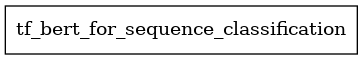

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True)

### 3) 모델 훈련

In [24]:
model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)

Epoch 1/3
198/198 [==============================] - 113s 494ms/step - loss: 1.1329 - accuracy: 0.5047 - val_loss: 0.6991 - val_accuracy: 0.7316
Epoch 2/3
198/198 [==============================] - 97s 493ms/step - loss: 0.6143 - accuracy: 0.7908 - val_loss: 0.5554 - val_accuracy: 0.8089
Epoch 3/3
198/198 [==============================] - 97s 492ms/step - loss: 0.4317 - accuracy: 0.8453 - val_loss: 0.5386 - val_accuracy: 0.8266


### 4) 모델 평가

In [25]:
evaluation = model.evaluate(val_dataset)

50/50 [==============================] - 7s 143ms/step - loss: 0.5386 - accuracy: 0.8266


---

## submission.csv 생성해보기

### 1) 파일 읽기 (`test.json`)

In [26]:
test_data_path ="/aiffel/aiffel/dktc/data/test.json"

with open(test_data_path, "r", encoding="utf-8") as json_file:
    test = json.load(json_file)

### 2) 테스트 데이터 읽으면서 예측해보기

In [27]:
test_predicst = list()

for key in test:
    test_sentence = test[key]['text']
    
    test_encodings = tokenizer(test_sentence, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    test_predictions = model.predict({
        "input_ids": test_encodings["input_ids"],
        "token_type_ids": test_encodings["token_type_ids"],
        "attention_mask": test_encodings["attention_mask"]
    }) # [ 0.7805823,  2.6188664, -2.0281641, -0.9672525]
    test_class_probabilities = tf.nn.softmax(test_predictions.logits, axis=-1).numpy() # [[0.13297564 0.8358507  0.00801584 0.02315779]]
    test_predicted_class = np.argmax(test_class_probabilities, axis=1) # [ 1 ]
    test_predicst.append(test_predicted_class[0])

### 3) `submission.csv` 파일을 위한 `DataFrame` 생성

In [28]:
def labelnum_to_text(x):
    if x == 1 : # 갈취
        return '01'
    if x == 2 : # 직장
        return '02'
    if x == 3 : # 기타
        return '03'
    if x == 0 : # 협박 
        return '00'

submission = pd.DataFrame({'class':test_predicst}, index=list(test.keys()))
submission['class'] = submission['class'].apply(labelnum_to_text)
submission

,class
t_000,00
t_001,02
t_002,02
t_004,03
t_005,00
...,...
t_495,02
t_496,03
t_497,01
t_498,02


### 4) CSV 파일 저장

In [29]:
# 파일명 설정
file_name = "submission_test2_preprocess_sentence.csv"

In [30]:
# 파일 생성
submission.to_csv(file_name)

# 테스트 회고

1. `OOM Error`로 인해 `MAX_LEN`를 크게 테스트 해보지 못했다. (ex: `300`)
2. 검증 데이터를 임의로 설정하였다. (`train.csv` 파일로부터)
3. 데이터에 대해 전처리를 `preprocess_sentence()`를 통해 수행하였다.